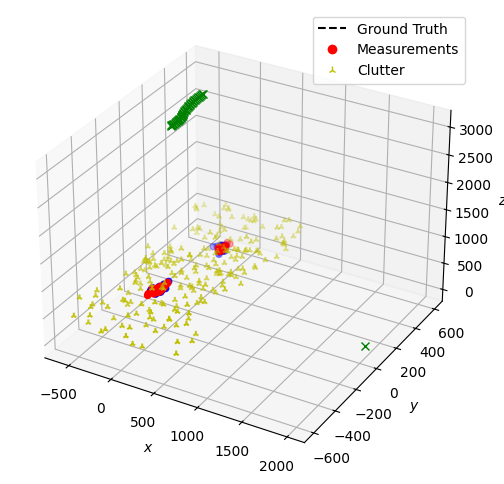

In [1]:
from copy import deepcopy
import numpy as np
from datetime import datetime

start_time = datetime.now()
num_steps = 50

from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel,\
                                               ConstantVelocity
truth_transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(0.5), ConstantVelocity(0.5), ConstantVelocity(0.5)))

from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from stonesoup.types.state import GaussianState
gt_simulator = MultiTargetGroundTruthSimulator(
    transition_model=truth_transition_model,
    initial_state=GaussianState([0, 0, 0, 0, 500, 0], np.diag([100, 1, 100, 1, 100, 1]),
                                timestamp=start_time),
    birth_rate=0,
    death_probability=0,
    number_steps=num_steps,
    preexisting_states=[[-100, 4, -200, 0.5, 500, 0], [0, 5, 300, -0.5, 500, 0]]
)

from stonesoup.models.clutter.clutter import ClutterModel
clutter_model = ClutterModel(
    clutter_rate=2.0,
    distribution=np.random.default_rng().uniform,
    dist_params=((-600.0, 600.0), (-600.0, 600.0), (250.0, 750.0))
)

from stonesoup.sensor.radar.radar import RadarElevationBearingRange
from stonesoup.types.array import CovarianceMatrix
from stonesoup.types.array import StateVector
from stonesoup.platform.base import MovingPlatform
from stonesoup.types.state import State

radar1 = RadarElevationBearingRange(
    ndim_state=6,
    position_mapping=(0, 2, 4),
    noise_covar=CovarianceMatrix(np.diag([np.deg2rad(0.005), np.deg2rad(0.005), 0.05])),
    mounting_offset=StateVector([10, 0, 0]),
    clutter_model=clutter_model,
    max_range=3500
)

# Mount the radar onto a moving platform. The platform starts at [-250, 50, 3000]
# with velocity [1, 5, 0] and moves according to a constant velocity model with low noise
sensor1_initial_loc = StateVector([[-250], [1], [50], [5], [3000], [0]])
initial_state = State(sensor1_initial_loc, start_time)
sensor1_transition_model = CombinedLinearGaussianTransitionModel(
    [ConstantVelocity(0.3), ConstantVelocity(0.3), ConstantVelocity(0.3)])
sensor1_platform = MovingPlatform(
    states=initial_state,
    position_mapping=(0, 2, 4),
    velocity_mapping=(1, 3, 5),
    transition_model=sensor1_transition_model,
    sensors=[radar1]
)

radar2_noise_covar = CovarianceMatrix(np.diag([np.deg2rad(0.005), np.deg2rad(0.005), 0.05]))
radar2 = RadarElevationBearingRange(
    ndim_state=6,
    position_mapping=(0, 2, 4),
    noise_covar=radar2_noise_covar,
    clutter_model=clutter_model,
    max_range=3000
)

# Make a platform and mount the radar
from stonesoup.platform.base import FixedPlatform
sensor2_platform = FixedPlatform(
    State([2000, 0, 50, 0, 0, 0]),
    position_mapping=[0, 2, 4],
    sensors=[radar2]
)

from stonesoup.simulator.platform import PlatformDetectionSimulator
radar_simulator = PlatformDetectionSimulator(
    groundtruth=gt_simulator,
    platforms=[sensor1_platform, sensor2_platform]
)

from stonesoup.plotter import Plotter, Dimension

# Lists to hold the detections from each sensor and the path of the airborne radar
s1_detections = []
s2_detections = []
radar1_path = []

# Extract the generator function from a copy of the simulator
sim = deepcopy(radar_simulator)
g = sim.detections_gen()

# Iterate over the time steps, extracting the detections, truths, and airborne sensor path
for _ in range(num_steps):
    s1_detections.append(next(g)[1])
    s2_detections.append(next(g)[1])
    radar1_path.append(sim.platforms[0].position)
truths = set(sim.groundtruth.groundtruth_paths)

# Plot the truths and detections
plotter = Plotter(dimension=Dimension.THREE)
plotter.plot_ground_truths(truths, [0, 2, 4])
plotter.plot_measurements(s1_detections, [0, 2, 4], color='blue')
plotter.plot_measurements(s2_detections, [0, 2, 4], color='red')

# Plot the radar positions
plotter.ax.plot(*zip(*radar1_path), marker='x', color='green')
plotter.ax.plot(2000, 50, 0, marker='x', color='green')

In [3]:
clutter_area = np.prod(np.diff(clutter_model.dist_params))
clutter_spatial_density = clutter_model.clutter_rate/clutter_area

from stonesoup.hypothesiser.probability import PDAHypothesiser
from stonesoup.updater.kalman import ExtendedKalmanUpdater
from stonesoup.predictor.kalman import ExtendedKalmanPredictor
from stonesoup.dataassociator.probability import JPDA
from stonesoup.deleter.error import CovarianceBasedDeleter
from stonesoup.initiator.simple import MultiMeasurementInitiator
from stonesoup.tracker.simple import MultiTargetMixtureTracker

# Updater
jpda_updater = ExtendedKalmanUpdater(measurement_model=None)

# Data Associator
predictor = ExtendedKalmanPredictor(truth_transition_model)
hypothesiser = PDAHypothesiser(
    predictor=predictor,
    updater=jpda_updater,
    clutter_spatial_density=clutter_spatial_density,
    prob_detect=0.9
)
data_associator = JPDA(hypothesiser=hypothesiser)

# Deleter
covariance_limit_for_delete = 500
deleter = CovarianceBasedDeleter(covar_trace_thresh=covariance_limit_for_delete)

# Initiator
s_prior_state = GaussianState([0, 0, 0, 0, 500, 0], np.diag([0, 50, 0, 50, 0, 50]))
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser = DistanceHypothesiser(
    predictor,
    jpda_updater,
    measure=Mahalanobis(),
    missed_distance=3
)

from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
initiator_associator = GNNWith2DAssignment(hypothesiser)
initiator_deleter = CovarianceBasedDeleter(covar_trace_thresh=500)
initiator = MultiMeasurementInitiator(
    prior_state=s_prior_state,
    measurement_model=None,
    deleter=initiator_deleter,
    data_associator=initiator_associator,
    updater=jpda_updater,
    min_points=2
)

jpda_tracker = MultiTargetMixtureTracker(
    initiator=initiator,
    deleter=deleter,
    detector=None,
    data_associator=data_associator,
    updater=jpda_updater
)

from stonesoup.updater.pointprocess import LCCUpdater
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
from stonesoup.hypothesiser.gaussianmixture import GaussianMixtureHypothesiser
from stonesoup.mixturereducer.gaussianmixture import GaussianMixtureReducer
from stonesoup.types.state import TaggedWeightedGaussianState
from stonesoup.tracker.pointprocess import PointProcessMultiTargetTracker

# Updater
kalman_updater = ExtendedKalmanUpdater(measurement_model=None)
updater = LCCUpdater(
    updater=kalman_updater,
    clutter_spatial_density=clutter_spatial_density,
    normalisation=True,
    prob_detection=0.9,
    prob_survival=0.9,
    mean_number_of_false_alarms=clutter_model.clutter_rate,
    variance_of_false_alarms=100
)

# Hypothesiser
kalman_predictor = ExtendedKalmanPredictor(truth_transition_model)
base_hypothesiser = DistanceHypothesiser(
    predictor=kalman_predictor,
    updater=kalman_updater,
    measure=Mahalanobis(),
    missed_distance=15,
    include_all=False
)
hypothesiser = GaussianMixtureHypothesiser(
    base_hypothesiser,
    order_by_detection=True
)

# Reducer
reducer = GaussianMixtureReducer(
    prune_threshold=1E-3,
    pruning=True,
    merge_threshold=200,
    merging=True
)

# Birth component
birth_covar = CovarianceMatrix(np.diag([10000, 10, 10000, 10, 10000, 10]))
birth_component = TaggedWeightedGaussianState(
    state_vector=[0, 0, 0, 0, 500, 0],
    covar=birth_covar**2,
    weight=0.5,
    tag=TaggedWeightedGaussianState.BIRTH,
    timestamp=start_time
)

# Tracker
gmlcc_tracker = PointProcessMultiTargetTracker(
    detector=None,
    hypothesiser=deepcopy(hypothesiser),
    updater=deepcopy(updater),
    reducer=deepcopy(reducer),
    birth_component=deepcopy(birth_component),
    extraction_threshold=0.90,
)

from stonesoup.updater.pointprocess import PHDUpdater

updater = PHDUpdater(
    kalman_updater,
    clutter_spatial_density=clutter_spatial_density,
    prob_detection=0.9,
    prob_survival=0.9
)

meas_fusion_tracker = PointProcessMultiTargetTracker(
    detector=None,
    hypothesiser=deepcopy(hypothesiser),
    updater=deepcopy(updater),
    reducer=deepcopy(reducer),
    birth_component=deepcopy(birth_component),
    extraction_threshold=0.90,
)

In [4]:
from stonesoup.updater.chernoff import ChernoffUpdater
from stonesoup.measures import Euclidean

# Updater
ch_updater = ChernoffUpdater(measurement_model=None)
updater = PHDUpdater(
    ch_updater,
    clutter_spatial_density=1E-15,
    prob_detection=0.9,
    prob_survival=0.9
)


# Hypothesiser
# The states being used as measurements are in Cartesian space. We will use Euclidean distance in
# the :class:`~.DistanceHypothesiser`, meaning that we need a bigger missed distance than the
# previous hypothesiser which used the Mahalanobis distance.
kalman_predictor = ExtendedKalmanPredictor(truth_transition_model)
base_hypothesiser = DistanceHypothesiser(
    kalman_predictor,
    ch_updater,
    Euclidean(),
    missed_distance=300,
    include_all=False
)
hypothesiser = GaussianMixtureHypothesiser(base_hypothesiser, order_by_detection=True)

# Reducer
# The states tend to have low weights when they are first initialized using this method, so we will
# keep the pruning threshold low.
ch_reducer = GaussianMixtureReducer(
    prune_threshold=1E-10,
    pruning=True,
    merge_threshold=200,
    merging=True
)

# Birth component
birth_covar = CovarianceMatrix(np.diag([100000, 100, 100000, 100, 100000, 100]))
ch_birth_component = TaggedWeightedGaussianState(
    state_vector=[0, 0, 0, 0, 500, 0],
    covar=birth_covar**2,
    weight=0.5,
    tag=TaggedWeightedGaussianState.BIRTH,
    timestamp=start_time
)

# Make tracker
track_fusion_tracker = PointProcessMultiTargetTracker(
    detector=None,
    hypothesiser=hypothesiser,
    updater=updater,
    reducer=deepcopy(ch_reducer),
    birth_component=deepcopy(ch_birth_component),
    extraction_threshold=0.90,
)

In [5]:
from stonesoup.metricgenerator.basicmetrics import BasicMetrics
from stonesoup.metricgenerator.ospametric import OSPAMetric
from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics
from stonesoup.metricgenerator.uncertaintymetric import SumofCovarianceNormsMetric
from stonesoup.dataassociator.tracktotrack import TrackToTruth
from stonesoup.metricgenerator.manager import SimpleManager

# Make the basic metric manager
basic_generator = BasicMetrics()
ospa_generator = OSPAMetric(c=10, p=1, measure=Euclidean([0, 2, 4]))
siap_generator = SIAPMetrics(position_measure=Euclidean(), velocity_measure=Euclidean())
uncertainty_generator = SumofCovarianceNormsMetric()

associator = TrackToTruth(association_threshold=30)
base_metric_manager = SimpleManager([basic_generator, ospa_generator, siap_generator,
                                     uncertainty_generator],
                                    associator=associator)

sensor1_mm, sensor2_mm = deepcopy(base_metric_manager), deepcopy(base_metric_manager)
meas_fusion_mm, track_fusion_mm = deepcopy(base_metric_manager), deepcopy(base_metric_manager)

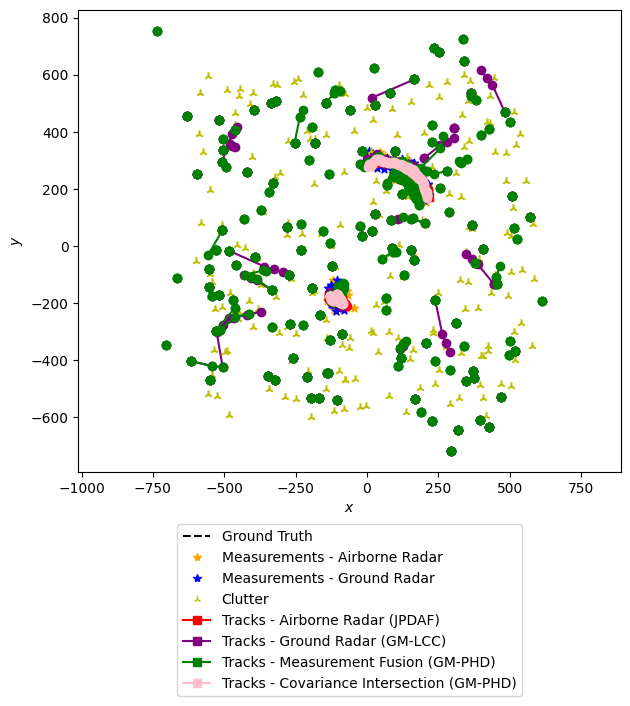

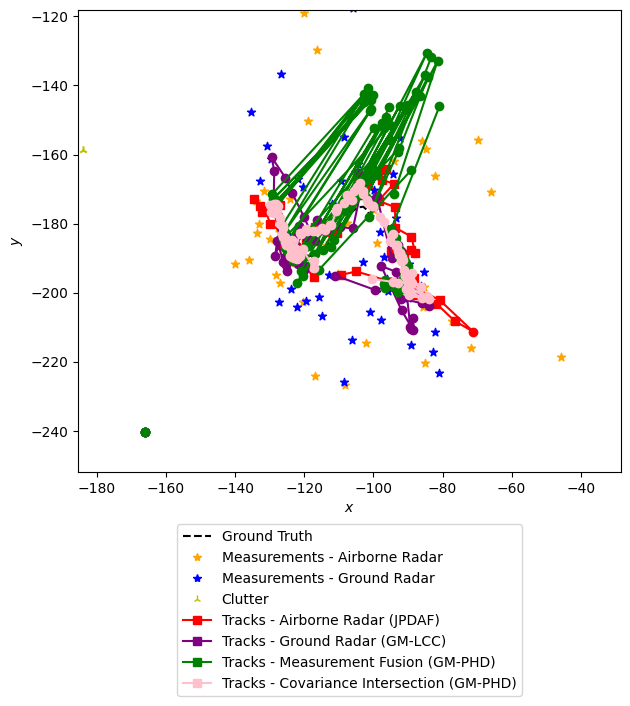

In [6]:
from stonesoup.feeder.track import Tracks2GaussianDetectionFeeder
from stonesoup.buffered_generator import BufferedGenerator
from stonesoup.reader.base import DetectionReader


class DummyDetector(DetectionReader):
    def __init__(self, *args, **kwargs):
        self.current = kwargs['current']

    @BufferedGenerator.generator_method
    def detections_gen(self):
        yield self.current
        
sensor1_detections, sensor2_detections = [], []
jpda_tracks, gmlcc_tracks = set(), set()
meas_fusion_tracks, track_fusion_tracks = set(), set()

sim_generator = radar_simulator.detections_gen()

for t in range(num_steps):

    # Run JPDA tracker from sensor 1
    s1d = next(sim_generator)
    sensor1_detections.extend(s1d[1])  # hold in list for plotting
    # Pass the detections into a DummyDetector and set it up as an iterable
    jpda_tracker.detector = DummyDetector(current=s1d)
    jpda_tracker.__iter__()
    # Run the tracker and store the resulting tracks
    _, sensor1_tracks = next(jpda_tracker)
    jpda_tracks.update(sensor1_tracks)

    # Run GM-LCC tracker from sensor 2
    s2d = next(sim_generator)
    sensor2_detections.extend(s2d[1])  # hold in list for plotting
    # Pass the detections into a DummyDetector and set it up as an iterable
    gmlcc_tracker.detector = DummyDetector(current=s2d)
    gmlcc_tracker.__iter__()
    # Run the tracker and store results
    time, sensor2_tracks = next(gmlcc_tracker)
    gmlcc_tracks.update(sensor2_tracks)

    # Run the GM-PHD for measurement fusion. This one gets called twice, once for each set of
    # detections. This ensures there is only one detection per target.
    for detections in [s1d, s2d]:
        meas_fusion_tracker.detector = DummyDetector(current=detections)
        meas_fusion_tracker.__iter__()
        _, tracks = next(meas_fusion_tracker)
        meas_fusion_tracks.update(tracks)

    # Run the GM-PHD for track fusion. Similar to the measurement fusion, this tracker gets run
    # twice, once for each set of tracks.
    for tracks_as_meas in [sensor1_tracks, sensor2_tracks]:
        dummy_detector = DummyDetector(current=[time, tracks_as_meas])
        track_fusion_tracker.detector = Tracks2GaussianDetectionFeeder(dummy_detector)
        track_fusion_tracker.__iter__()
        _, tracks = next(track_fusion_tracker)
        track_fusion_tracks.update(tracks)

    # ----------------------------------------------------------------------

    # Add ground truth data to metric managers
    truths = radar_simulator.groundtruth.current
    for manager in [sensor1_mm, sensor2_mm, meas_fusion_mm, track_fusion_mm]:
        manager.add_data(groundtruth_paths=truths[1], overwrite=False)

    # Add measurements to metric managers
    sensor1_mm.add_data(detections=s1d[1], overwrite=False)
    sensor2_mm.add_data(detections=s2d[1], overwrite=False)
    meas_fusion_mm.add_data(detections=s1d[1], overwrite=False)
    meas_fusion_mm.add_data(detections=s2d[1], overwrite=False)
    track_fusion_mm.add_data(detections=s1d[1], overwrite=False)
    track_fusion_mm.add_data(detections=s2d[1], overwrite=False)


# Ensure that all tracks have been extracted from the trackers
jpda_tracks.update(jpda_tracker.tracks)
gmlcc_tracks.update(gmlcc_tracker.tracks)
meas_fusion_tracks.update(meas_fusion_tracker.tracks)
track_fusion_tracks.update(track_fusion_tracker.tracks)

# Remove tracks that have just one state in them as they were probably from clutter
jpda_tracks = set([track for track in jpda_tracks if len(track) > 1])
gmlcc_tracks = set([track for track in gmlcc_tracks if len(track) > 1])
meas_fusion_tracks = set([track for track in meas_fusion_tracks if len(track) > 1])
track_fusion_tracks = set([track for track in track_fusion_tracks if len(track) > 1])

# Add tracks to metric managers
sensor1_mm.add_data(tracks=jpda_tracks, overwrite=False)
sensor2_mm.add_data(tracks=gmlcc_tracks, overwrite=False)
meas_fusion_mm.add_data(tracks=meas_fusion_tracks, overwrite=False)
track_fusion_mm.add_data(tracks=track_fusion_tracks, overwrite=False)

plotter1, plotter2 = Plotter(), Plotter()
for plotter in [plotter1, plotter2]:
    plotter.plot_ground_truths(set(radar_simulator.groundtruth.groundtruth_paths), [0, 2],
                               color='black')
    plotter.plot_measurements(sensor1_detections, [0, 2], color='orange', marker='*',
                              measurements_label='Measurements - Airborne Radar')
    plotter.plot_measurements(sensor2_detections, [0, 2], color='blue', marker='*',
                              measurements_label='Measurements - Ground Radar')
    plotter.plot_tracks(jpda_tracks, [0, 2], color='red',
                        track_label='Tracks - Airborne Radar (JPDAF)')
    plotter.plot_tracks(gmlcc_tracks, [0, 2], color='purple',
                        track_label='Tracks - Ground Radar (GM-LCC)')
    plotter.plot_tracks(meas_fusion_tracks, [0, 2], color='green',
                        track_label='Tracks - Measurement Fusion (GM-PHD)')
    plotter.plot_tracks(track_fusion_tracks, [0, 2], color='pink',
                        track_label='Tracks - Covariance Intersection (GM-PHD)')

    # Format the legend a bit. Set the position outside of the plot, and
    # swap the order of the clutter and ground radar measurements
    pos = plotter.ax.get_position()
    plotter.ax.set_position([pos.x0, pos.y0, pos.width * 0.7, pos.height])
    k = list(plotter.legend_dict.keys())
    k[2], k[3] = k[3], k[2]
    v = list(plotter.legend_dict.values())
    v[2], v[3] = v[3], v[2]
    plotter.ax.legend(handles=v, labels=k, loc='lower center', bbox_to_anchor=(0.5, -0.5))

plotter1.fig.show()

track = track_fusion_tracks.pop()
x_min = min([state.state_vector[0] for state in track])
x_max = max([state.state_vector[0] for state in track])
y_min = min([state.state_vector[2] for state in track])
y_max = max([state.state_vector[2] for state in track])

plotter2.ax.set_xlim(x_min-50, x_max+50)
plotter2.ax.set_ylim(y_min-50, y_max+50)

plotter2.fig.show()

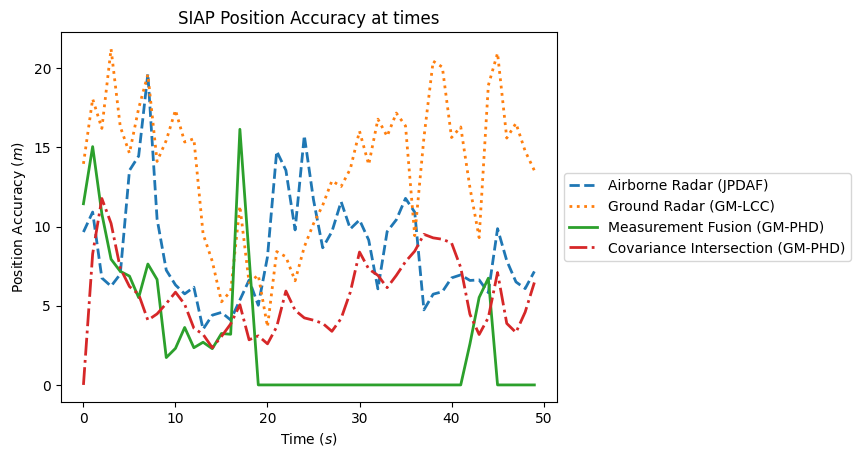

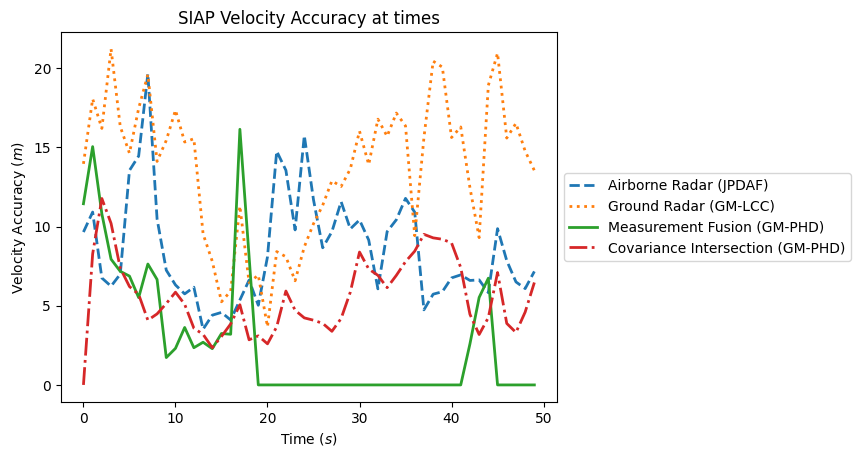

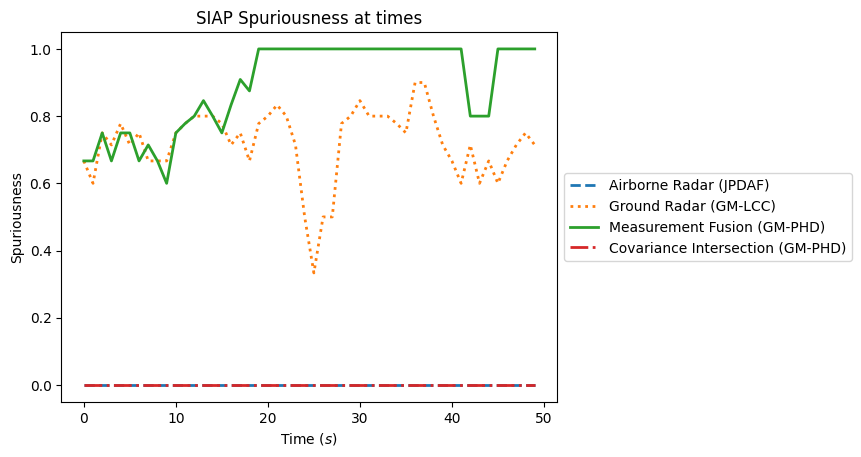

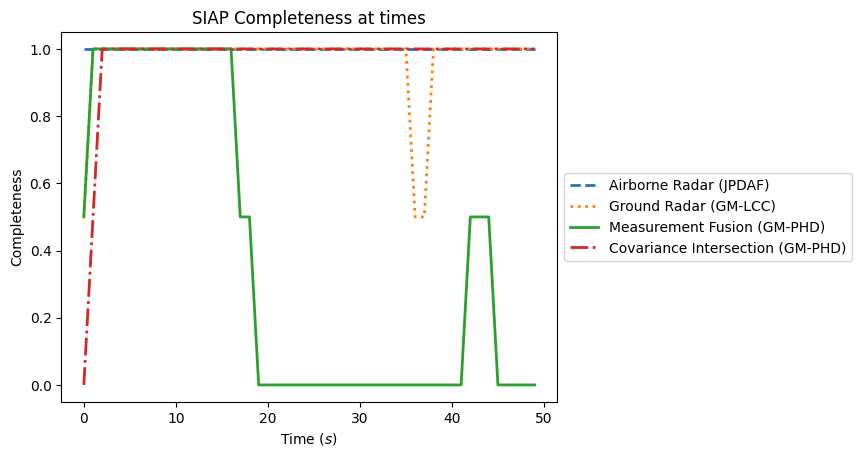

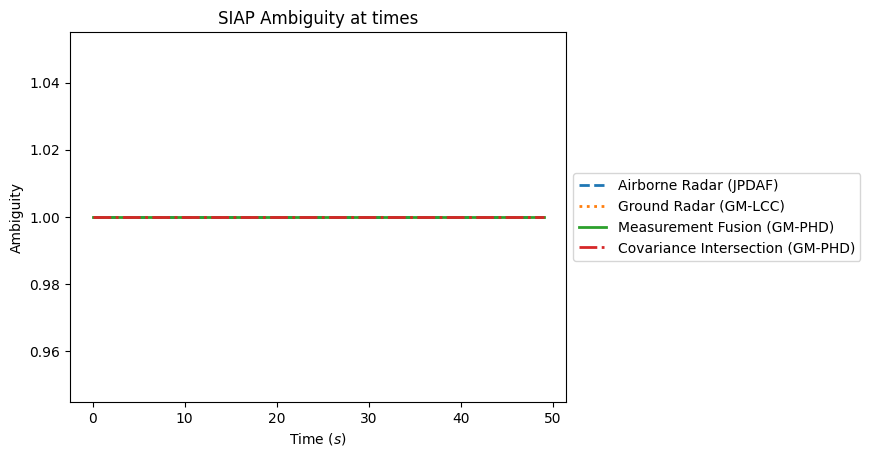

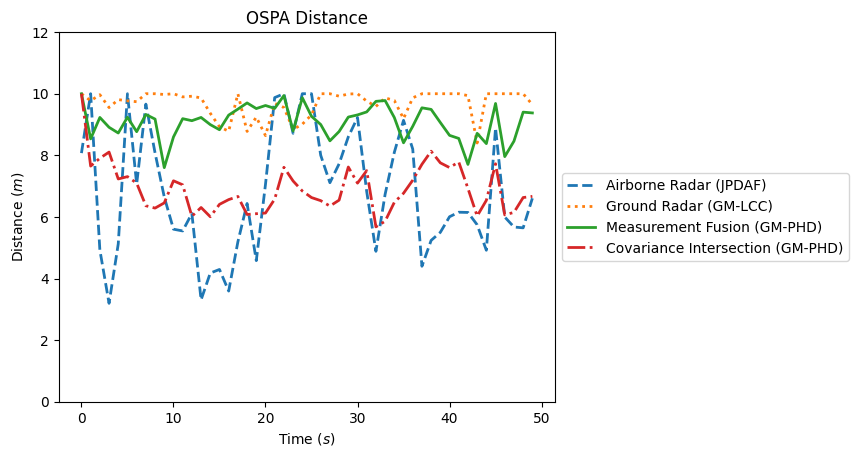

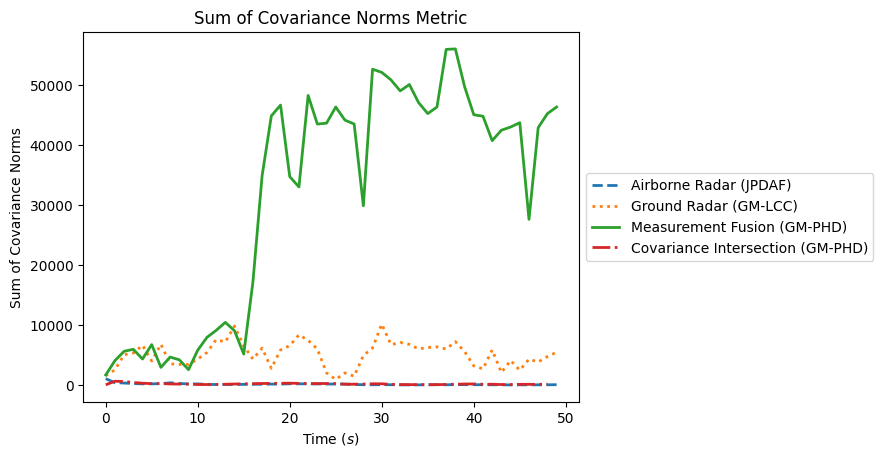

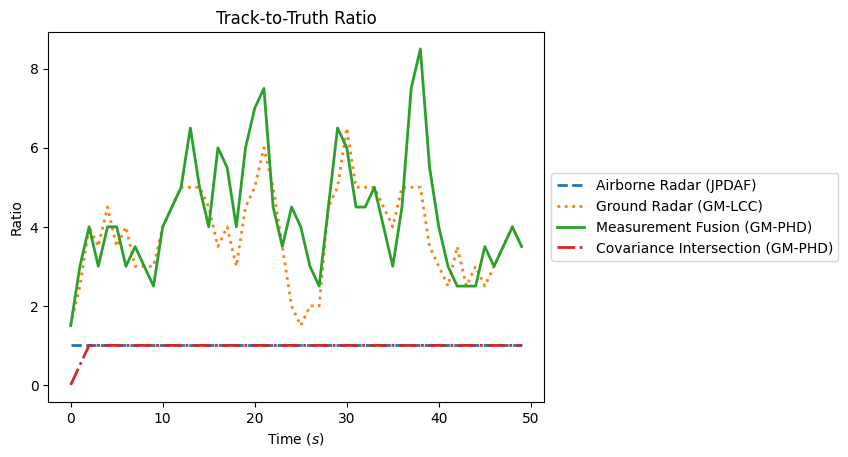

In [7]:
s1_metrics = sensor1_mm.generate_metrics()
s2_metrics = sensor2_mm.generate_metrics()
meas_fusion_metrics = meas_fusion_mm.generate_metrics()
track_fusion_metrics = track_fusion_mm.generate_metrics()

from matplotlib import pyplot as plt
from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics

# Legend labels for each type of tracker
labels = ['Airborne Radar (JPDAF)', 'Ground Radar (GM-LCC)', 'Measurement Fusion (GM-PHD)',
          'Covariance Intersection (GM-PHD)']
linestyles = ['dashed', 'dotted', 'solid', 'dashdot']

# Iterate through the SIAP and OSPA metrics
for metric_name in ['SIAP Position Accuracy at times', 'SIAP Velocity Accuracy at times',
                    'SIAP Spuriousness at times', 'SIAP Completeness at times',
                    'SIAP Ambiguity at times', 'OSPA distances', 'Sum of Covariance Norms Metric']:
    fig, ax = plt.subplots()

    # Plot the metrics from each metric manager
    for tracker_metrics, label, line in zip([s1_metrics, s2_metrics, meas_fusion_metrics,
                                             track_fusion_metrics], labels, linestyles):
        metrics = tracker_metrics[metric_name]
        ax.plot([m.value for m in metrics.value], linewidth=2, label=label, linestyle=line)

    # Set x and y labels and title
    ax.set_xlabel("Time $(s)$")
    if metric_name.startswith('OSPA'):
        ax.set_title('OSPA Distance')
        ax.set_ylabel('Distance')
        ax.set_ylim(0, 12)  # change y axis range for OSPA distance
    elif metric_name.startswith('Sum of'):
        ax.set_title(metric_name)
        ax.set_ylabel('Sum of Covariance Norms')
    else:
        ax.set_title(metric_name)
        ax.set_ylabel(metric_name[5:-9])

    # Add units to y axis where applicable
    if metric_name.startswith('SIAP Position') or metric_name.startswith('SIAP Velocity') \
       or metric_name.startswith('OSPA'):
        ax.set_ylabel(ax.yaxis.get_label().get_text() + ' $(m)$')

    # Add legend
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


# Plot Track to Truth Ratio
fig, ax = plt.subplots()
times = sensor1_mm.list_timestamps()

# Iterate through the metric managers. For each one, go through the list of all timesteps
# and calculate the ratio at that time
for manager, label, line in zip([sensor1_mm, sensor2_mm, meas_fusion_mm, track_fusion_mm],
                                labels, linestyles):
    ratios = []
    for time in times:
        num_tracks = SIAPMetrics.num_tracks_at_time(manager=manager, timestamp=time)
        num_truths = SIAPMetrics.num_truths_at_time(manager=manager, timestamp=time)
        ratios.append(num_tracks / num_truths)
    plt.plot(ratios, linewidth=2, label=label, linestyle=line)

ax.set_title('Track-to-Truth Ratio')
ax.set_ylabel('Ratio')
ax.set_xlabel('Time $(s)$')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))